In [1]:
import datetime as dt
import pandas as pd

import glob
import os.path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams  
import matplotlib.mlab as mlab


import os
import scipy.io as sio
import h5py

%matplotlib inline

In [2]:
#PAMoD sims
SimResults = pd.DataFrame(columns=['Service time','Wait time','Energy Demand','Tot. expenditure',
                                   'Gen. cost','DFW price','TSO expenditure','Sim. type'])

#Unzip all files that end in csv.zip
#Simfilenamepattern =  'DFWSim_*_10h_7200horizon_*Apr*_v5_infcycles_5min.mat'
Simfilenamepattern =  'DFWSim_*.mat'
Simfilenames = glob.glob(Simfilenamepattern)
for Simfilename in Simfilenames:
    with h5py.File(Simfilename, 'r') as SimRes:
        BaseMVA = np.array(SimRes['BaseMVA'])
        try:
            allWaitTimes = np.array(SimRes['Stats']['allWaitTimes']) #mean(Stats.allWaitTimes)
            avgWaitTime = np.mean(allWaitTimes)
            allTravelTimes = np.array(SimRes['Stats']['allServiceTimes'])
            avgTravelTime = np.mean(allTravelTimes)
        except:
            allWaitTimes = np.NaN
            avgWaitTime = np.NaN
            allTravelTimes = np.NaN
            avgTravelTime = np.NaN
        
        allPNViolationBool = np.sum(np.array(SimRes['Stats']['PowerNetworkViolationBool']))
        # These are a mess -> we get them from MATLAB
        #allPNViolationUP = np.sum(np.array(SimRes['Stats']['PowerNetworkViolationQUP']))
        #allPNViolationDN = np.sum(np.array(SimRes['Stats']['PowerNetworkViolationQDN']))
        #allPNViolation = allPNViolationUP+allPNViolationDN
        
        ControllerMode = u''.join(unichr(c) for c in SimRes['settings']['ControllerMode'])
        Energy_demand_tot = np.array(SimRes['PowerStats']['Energy_demand_tot'])[0][0]
        Gen_cost_tot = np.array(SimRes['PowerStats']['Gen_cost_tot'])[0][0]
        Ext_expense_tot = np.array(SimRes['PowerStats']['Ext_expense_tot'])[0][0]
        TSO_expense_tot = np.array(SimRes['PowerStats']['TSO_expense_tot'])[0][0]
        #print np.array(SimRes['PowerStats']['DFW_expense_tot'])[0][0]
        
        #We don't have the unit cost in DFW, so we compute it
        #sum((Ext_loads(isbusinDallas,:).*Stats.PowerPricesLog(isbusinDallas,:)))./sum(Ext_loads(isbusinDallas,:))
        Ext_loads = np.array(SimRes['PowerStats']['Ext_loads_log'])
        isbusinDallas = np.array(SimRes['isbusinDallas'])
        isbusinDallasB = isbusinDallas>0
        isbusinDallasB = isbusinDallasB[:,0]
        PowerPricesLog = np.array(SimRes['Stats']['PowerPricesLog'])
        DFW_unit_expense_tot = np.sum(Ext_loads[:,isbusinDallasB]*PowerPricesLog[:,isbusinDallasB])/np.sum(Ext_loads[:,isbusinDallasB])
#        print DFW_unit_expense_tot
        _record = {'Service time': avgTravelTime+avgWaitTime,
                   'Wait time': avgWaitTime,
                   'Energy Demand': Energy_demand_tot,
                   'Tot. expenditure': Ext_expense_tot+TSO_expense_tot,
                   'Gen. cost': Gen_cost_tot,
                   'DFW price': DFW_unit_expense_tot,
                   'TSO expenditure': TSO_expense_tot, 
                   'Sim. type': ControllerMode,
                   'PN violation times': allPNViolationBool,
                   #'PN violation MWh': allPNViolation
                  }
        SimResults = SimResults.append(_record,ignore_index=True)

In [3]:
SimResults.groupby('Sim. type').mean()
#SimResults.groupby('Sim. type').std()

,Service time,Wait time,Energy Demand,Tot. expenditure,Gen. cost,DFW price,TSO expenditure,PN violation times
Sim. type,,,,,,,,
GREEDY,5670.547065,1120.309952,5080.094914,1.234415e+13,1.224719e+07,4.595442e+09,4.786741e+12,81.571429
PAMoD,5689.058483,1196.471486,5077.297584,1.530489e+07,1.220922e+07,3.015353e+03,2.346730e+05,0.000000
POWER,NaN,NaN,5000.014827,1.506736e+07,1.197556e+07,3.013636e+03,0.000000e+00,0.000000


# Plot the results distribution

In [4]:



# We need this to ensure output is not truncated
pd.set_option('display.max_colwidth', -1)

In [5]:
PAMoD_results = SimResults[SimResults['Sim. type'] == 'PAMoD']
#PAMoD_results.convert_objects(convert_numeric=True)

Greedy_results = SimResults[SimResults['Sim. type'] == 'GREEDY']
#Greedy_results.convert_objects(convert_numeric=True)

In [6]:
mycolumns = SimResults.columns
mycolumns = mycolumns[mycolumns != u'Sim. type']

In [7]:
mycolumns = mycolumns[mycolumns != u'Sim. type']

/home/frossi/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/frossi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/frossi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/frossi/.local/lib/python2.7/site-packages/matplotlib/mlab.py:1541: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)
/home/frossi/.local/lib/python2.7/site-packages/matplotlib/mlab.py:1541: RuntimeWarning: invalid value encountered in multiply
  return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)


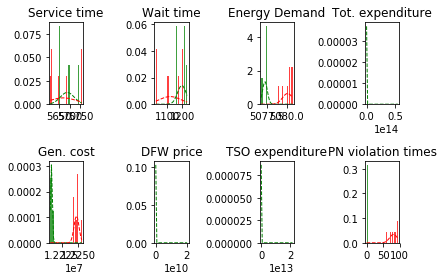

In [8]:
# the histogram of the data
#for column_name in mycolumns:
rownum=2
colnum=4
f, axes = plt.subplots(rownum, colnum)
axisct=0
rcParams['figure.figsize'] = (16, 8)

for column_name in mycolumns:
    myaxis = axes[axisct/colnum,axisct%colnum]
    mydataP= pd.to_numeric(PAMoD_results[column_name])
    mydataG= pd.to_numeric(Greedy_results[column_name])
    #plt.plot()
    allData = pd.concat([mydataG,mydataP],ignore_index=True)
    n, _bins, patches = myaxis.hist(allData, 30, normed=1, facecolor='magenta', alpha=0.0)

    n, _bins, patches = myaxis.hist(mydataP, bins = _bins, normed=1, facecolor='green', alpha=0.75)
    # add a 'best fit' line
    y = mlab.normpdf(_bins,np.mean(mydataP),np.std(mydataP))
    l = myaxis.plot(_bins, y, 'g--', linewidth=1)


    n, _bins, patches = myaxis.hist(mydataG, bins = _bins, normed=1, facecolor='red', alpha=0.75)
    # add a 'best fit' line
    y = mlab.normpdf(_bins,np.mean(mydataG),np.std(mydataG))
    l = myaxis.plot(_bins, y, 'r--', linewidth=1)

    myaxis.set_title(column_name,fontsize=12)
    axisct+=1
plt.tight_layout()
plt.savefig('RTSims_alldata.png',bbox_inches='tight',transparent=False,dpi=300)